In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


#!/usr/bin/env python
# coding: utf-8

# ============================================================================================
# importing libraries

# original libraries from IRI version
import pycpt
import packaging
min_version = '2.5.0'
assert packaging.version.parse(pycpt.__version__) >= packaging.version.parse(min_version), f'This notebook requires version {min_version} or higher of the pycpt library, but you have version {pycpt.__version__}. Please close the notebook, update your environment, and load the notebook again. See https://iri-pycpt.github.io/installation/'

import cptdl as dl 
from cptextras import get_colors_bars
import datetime as dt
import numpy as np
from pathlib import Path
import xarray as xr

import pandas as pd
import numpy as np
import datetime
#from mpl_toolkits.basemap import Basemap #only needed by the original pycpt plotting functions
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# libraries added to support functionality at CSC
import os,sys
import importlib
import functions_plot as fun
importlib.reload(fun)
from functions_pycpt import *

# In[23]:


# ============================================================================================
# parsing parameters defining the forecast
#

# parsing forecast parameters from command line arguments - target season, domain, model etc..
#
#in operational setting - these are the only values that will have to change from month to month
#
parse_args=False
if parse_args:
    datadir=sys.argv[1]
    mapdir=sys.argv[2]
    model=sys.argv[3]
    predictor_var=sys.argv[4]
    predictor_domain=sys.argv[5]
    predictand_institution=sys.argv[6]
    predictand_var=sys.argv[7]
    predictand_domain=sys.argv[8]
    MOS=sys.argv[9]
    init_date=sys.argv[10]
    basetime=sys.argv[11]
    skill_mask_code=sys.argv[12]
    overwrite=bool(int(sys.argv[13]))
else:
    datadir="../data"
    mapdir="../maps"
    model="SEAS51"
    
    predictor_var="SST"
    predictor_domain="nino34"
    
    predictor_var="T2M"
    predictor_domain="sadc"
    
    predictand_institution="UCSB"
    predictand_var="PRCP"
    
    predictand_institution="ERA5"
    predictand_var="TX"
    
    predictand_domain="sadc"
    MOS="CCA"
    init_date="2023-10-01"
    basetime="seas"
    skill_mask_code="both"
    overwrite=False
    
# In[29]:


# ============================================================================================
# forecast parameters defined "in script"
#
# first and last year of the hindcast. This is set here to be the same for each forecast model, but potentially can be diversified between models
first_hindcast_year,last_hindcast_year=1993,2015

#is where all data - inputs and outputs are going to be stored. Sub-directory structure will be created automatically in this root directory to capture target domain, predictand, models, initializtion date, target season etc...
# this one has to be changed/adjusted if scripts are moved or a different directory structure is used
fcstrootdir="{}/forecast/{}".format(datadir,model)
localpredictandrootdir="{}/local_predictand".format(datadir)
maprootdir="{}/forecast/{}".format(mapdir,model)

#file with sadc country boundaries to be overlaid on maps
overlayfile="../csis/gis/sadc_continental.geojson"

predictor_domain_file="./dictionaries/predictor_domains.json"
predictand_domain_file="./dictionaries/predictand_domains.json"

#location of logo image
logofile="../csis/img/csclogo-small.png"

#this defines level of messages that this script is going to return to log
verbose=True

#defining whether or not calibration diagnostics are plotted
# note that as per March 2024, eofs plotting crashes if MOS is PCR! It is a bug, and IRI are aware... 
do_plot_eof_modes=False
do_plot_cca_modes=False

#internal pycpt parameter that describes whether or not data are to be re-downloaded 
force_download = False

#whether forecast calibration is done intgeractively
interactive = False

#these skill metrics will be plotted:
#names correspond to skill metrics available in the output of pycpt.evaluate_models()
skill_metrics_to_plot = [
        "rpss",
        "genroc",
        "spearman",
        "pearson",
        "2afc"
]

#these forecast metrics will be plotted
#these names are "bespoke", implemented in this script only, they are not "native" to pycpt
#defined as a function of predictand 
if predictand_var=="PRCP":
    fcst_outputs_to_plot=[
        "det",
        "det-absanom",
        "det-percanom",
        "prob-tercile"]
else:
    fcst_outputs_to_plot=["det",
        "det-absanom",
        "prob-tercile"]

#this defines predictands that will be read locally and not downloaded from IRI
local_predictands=["ERA5.TX"]

#these lead time will be calculated for different basetimes
leadtimes={"seas": [0,1,2,3],
        "mon": [0,1,2,3,4]}

  
    
# ============================================================================================
#
# defining dictionaries and functions
#
# these will be used by different functions to get parameters for the forecast 
# as requested by the arguments passed to this script
#
  

 
#this sets up whether plotting is done with and/or without mask
skillmasks={"no":[[False,""]],
"yes":[[True,"-m"]],
"both":[[False,""], [True,"-m"]]}


#this is necessary, because variable name in the netcdf file that pycpt creates is different than the "nominal" variable name
obs_ncvars={"UCSB.PRCP":"prcp",
	"UCSB.TMEAN":"tmean",
	"ERA5.TMEAN":"TMEAN",
	"ERA5.TX":"TX",
	"ERA5.TN":"TN",
	}


labels={"UCSB.PRCP":"CHIRPS",
	"UCSB.TMEAN":"CHIRTS",
	"ERA5.TMEAN":"ERA5",
	"ERA5.TN":"ERA5",
	"ERA5.TX":"ERA5",
	"PRCP":"rainfall",
	"TX":"maximum temperature",
	"TMAX":"maximum temperature",
	"TN":"minimum temperature",
	"TMIN":"minimum temperature",
	"TMEAN":"mean temperature",
	"T2m":"mean temperature",
	}

sources={"SEAS51":"ECMWF SEAS 5.1",
         "METEOFRANCE8":"MeteoFrance System 8",
        "MME01":"Multi-model ensemble (SEAS5.1 & Meteofrance System 8)"
        }   

source="{} model".format(sources[model])

# ============================================================================================
# picking up parameters for the requested forecast
#

#domain parameters
predictor_domain_params = get_domain_params(predictor_domain_file,predictor_domain)
predictand_domain_params = get_domain_params(predictand_domain_file,predictand_domain)
predictand_name="{}.{}".format(predictand_institution,predictand_var)


predtxt="{}.{}".format(predictand_institution,predictand_var)

#catching possible errors... 
if predtxt not in labels.keys():
    print("ERROR: There is no entry for requested predictand in labels dictionary: {}".format(predtxt))
    sys.exit()
    
predictand_dataset_label=labels[predtxt]

#catching possible errors... 
if predictand_var not in labels.keys():
    print("ERROR: There is no entry for requested predictand variable in labels dictionary: {}".format(predictand_var))
    sys.exit()

fcstvar_label=labels[predictand_var]





    
# ============================================================================================
# setting internal parameters of pycpt
#

#these are user-defined, so they have to be set here explicitly rather than later in the middle of other code
cpt_args = { 
    'transform_predictand': None,  # transformation to apply to the predictand dataset - None, 'Empirical', 'Gamma'
    'tailoring': None,  # tailoring None, 'Anomaly'
    'cca_modes': (1,3), # minimum and maximum of allowed CCA modes 
    'x_eof_modes': (1,8), # minimum and maximum of allowed X Principal Componenets 
    'y_eof_modes': (1,6), # minimum and maximum of allowed Y Principal Components 
    'validation': 'crossvalidation', # the type of validation to use; only 'crossvalidation' is supported for now
    'drymask': False, #whether or not to use a drymask of -999
    'scree': True, # whether or not to save % explained variance for eof modes
    'crossvalidation_window': 5,  # number of samples to leave out in each cross-validation step 
    'synchronous_predictors': True, # whether or not we are using 'synchronous predictors'
}
print("done")

# In[31]:


# ============================================================================================
#
# processing starts here
#

#iterating through lead times
#for lead_time in leadtimes[basetime]:
for lead_time in [0]:
    print()
    print("----------------------------------")
    print("processing lead time: {}".format(lead_time))
    
    #processing forecast date and target information
    #this returns a dictionary
    season_params = get_season_params(lead_time, init_date, basetime)
    
    if verbose:
        print("season parameters:\n",season_params)

    # this is target season's code, e.g. JFM
    target_seas=season_params["target_seas"]

    # To read predictand data from a local file instead,
    # set local_predictand_file to the full pathname of the file. e.g.
    # local_predictand_file = "/home/aaron/src/pycpt_notebooks/obs_PRCP_Oct-Dec.tsv"
    
    #here, local predictand file is picked up if predictand variable and predictand institution 
    # are in the local predictands dictionary defined above
    
    local_predictand_file = None

    if verbose:
        print("predictand:", predictand_name)

    if predictand_name in local_predictands:
        # internal parameter of pycpt - if set, then local file is used as predictand
        local_predictand_file = "{}/{}/{}/{}/{}/{}.{}_{}.tsv".format(localpredictandrootdir,
                                                                  predictand_institution,
                                                                  basetime,
                                                                  predictand_domain,
                                                                  predictand_var,
                                                                  predictand_var,
                                                                  predictand_institution,
                                                                  target_seas)
        print("using local predictand {}".format(local_predictand_file))
        
        if not os.path.exists(local_predictand_file):
            print("ERROR: Local predictand file does not exist: {}".format(local_predictand_file))
            sys.exit()
    else:
        print("using predictand from IRI: {}".format(predictand_name))
        if predictand_name not in dl.observations.keys():
            print("ERROR. Could not find predictand {}".format(predictand_name))
            sys.exit()
        
    # Use dl.observations.keys() to see all options for predictand 
    # and dl.hindcasts.keys() to see all options for predictors.
    # Make sure your first_year & final_year are compatible with 
    # your selections for your predictors and predictands.

    predictor_name="{}.{}".format(model,predictor_var)

    if verbose:
        print("predictor:", predictor_name)

    #checking if predictors and predictand are defined correctly
    if predictor_name not in dl.hindcasts.keys():
        print("ERROR. Could not find predictor {}".format(predictor_name))
        sys.exit()
        
    #checking if root directory exists
    if not os.path.exists(fcstrootdir):
        print("ERROR. Root directory does not exist {}".format(fcstrootdir))
        sys.exit()
        
    #this is definition of output directory
    fcstdir = "{}/{}/{}/{}/{}-{}/{}-{}".format(fcstrootdir,
                                 basetime,
                                 predictand_domain,
                                 predictand_var,
                                 season_params["fdate"].strftime("%Y%m"),
                                 target_seas,
                                 predictor_var,
                                 predictor_domain)
    # In[14]:


    #pycpt download and evaluation function have to receive domain_dir, and put input data, output data and figures
    # into three subdirectories in that dir, namely output, data and figures. In the original PyCPT, this directory 
    # structure is set up by pycpt.setup(), but here we have our own definition, so that the forecast directory structure 
    # corresponds to directory structure adopted in CSIS 
    #this is is basically what pycpt.setup() does:
    for subdir in ["output","data","figures"]:
        adir="{}/{}".format(fcstdir,subdir)
        if not os.path.exists(adir):
            print("creating directory: {}".format(adir))
            os.makedirs(adir, exist_ok=True)
            
    fcstdir = Path(fcstdir)
    print("\nOutput files will be stored in {}".format(str(fcstdir)))

    #download_args is dictionary used by pycpt. It is created here from parameters processed earlier
    download_args = { 
        # 'fdate':
        #   The initialization date of the model forecasts / hindcasts.
        #   This field is defined by a python datetime.datetime object,
        #   for example: dt.datetime(2022, 5, 1) # YYYY, MM, DD as integers
        #   The year field is only used for forecasts, otherwise ignored.
        #   The day field is only used in subseasonal forecasts, otherwise ignored.
        #   The month field is an integer representing a month - ie, May=5.
        'fdate': season_params["fdate"],
        # 'fdate':  dt.datetime(2023, 11, 1),

        # 'first_year':
        #   The first year of hindcasts you want. **NOT ALL MODELS HAVE ALL YEARS**.
        #   Double check that your model has hindcast data for all years in [first_year, final_year].
        #   This field is defined by a python integer representing a year, e.g. 1993.
        'first_year': first_hindcast_year,  

        # 'final_year':
        #   The final year of hindcasts you want. **NOT ALL MODELS HAVE ALL YEARS**.
        #   Double check that your model has hindcast data for all years in [first_year, final_year].
        #   This field is defined by a python integer representing a year, e.g. 2016.
        'final_year': last_hindcast_year,  

        # 'lead_low': 
        #   The number of months from the first of the initialization month to the center of 
        #   the first month included in the target period. Always an integer + 0.5. 
        #   This field is defined by a python floating point number 
        #   for example  a lead-1 forecast would use lead_low=1.5, if you want init=may, target=Jun-..
        'lead_low': season_params["lead_low"],
        # 'lead_low': 2.5,

        # 'lead_high': 
        #   The number of months from the first of the initialization month to the center of 
        #   the last month included in the target period. Always an integer + 0.5. 
        #   This field is defined by a python floating point number 
        #   for example  a forecast initialized in may, whose target period ended in Aug, 
        #   would use lead_high=3.5
        'lead_high': season_params["lead_high"], 
        #'lead_high': 4.5, 

        # 'target': 
        #   Mmm-Mmm indicating the months included in the target period of the forecast. 
        #   This field is defined by a python string, with two three-letter month name abbreviations 
        #   whose first letters are capitalized, and all other letters are lowercase
        #   and who are separated by a dash character. 
        #   For example, if you wanted a JJA target period, you would use 'Jun-Aug'.
        'target': season_params["target"],
        #'target': 'Jan-Mar',

        # 'predictor_extent':
        #   The geographic bounding box of the climate model data you want to download.
        #   This field is defined by a python dictionary with the keys "north", "south",
        #   "east", and "west", each of which maps to a python integer representing the 
        #   edge of a bounding box. i.e., "north" will be the northernmost boundary,
        #   "south" the southernmost boundary.
        #   Example: {"north": 90, "south": -90, "east": 0, "west": 180}
        'predictand_extent': predictand_domain_params,

        # 'predictand_extent':
        #   The geographic boundingl box of the observation data you want to download.
        #   This field is defined by a python dictionary with the keys "north", "south",
        #   "east", and "west", each of which maps to a python integer representing the 
        #   edge of a bounding box. i.e., "north" will be the northernmost boundary,
        #   "south" the southernmost boundary.
        #   Example: {"north": 90, "south": -90, "east": 0, "west": 180}
        'predictor_extent': predictor_domain_params,

        # 'filetype':
        #   The filetype to be downloaded. for now, it saves a lot of headache just to set this equal
        #   to 'cptv10.tsv' which is a boutique plain-text CPT filetype based on .tsv + metadata.
        'filetype': 'cptv10.tsv'
    }



    # ============================================================================================
    # downloading data
    #
    # there is no need to check overwrite parameter, as this is defined by force_download
    print(predictand_name)
    print(local_predictand_file)
    print(predictor_name)
    print(download_args)
    print(fcstdir)
    print(force_download)
    
    try:
        Y, hindcast_data, forecast_data = pycpt.download_data(predictand_name, local_predictand_file, [predictor_name], download_args, fcstdir, force_download)
        predictand_file=predictand_name
    except:
        print("ERROR. could not download data. check if there is access to internet. exiting...")
        sys.exit()

    if local_predictand_file:
        #saving local predictand into the case_dir, just to have the predictor file saved in the same directory as forecasts
        predictand_file="{}/data/{}.nc".format(str(fcstdir),predictand_name)
        if force_download or (not os.path.exists(predictand_file)):
            Y.to_netcdf(predictand_file)

    # ============================================================================================
    # calibrating forecast
    #
    fcstfile="{}/output/{}_realtime_{}_forecasts.nc".format(str(fcstdir), predictor_name, MOS.lower())

    if overwrite or (not os.path.exists(fcstfile)):
        print("processing forecast to {}".format(fcstfile))
        hcsts, fcsts, skill, pxs, pys = pycpt.evaluate_models(hindcast_data, MOS, Y, forecast_data, cpt_args, fcstdir, [predictor_name], interactive)
        calibrated=True
    else:
        calibrated=False
        print("Forecast file {} exists. skipping calibration...".format(fcstfile)) 

    predictand_file="{}/data/{}.nc".format(fcstdir,predictand_name)        

    
    # ============================================================================================
    # plotting figures
    #


    # ============================================================================================
    # this is not strictly necessary in operational, but can potentially be run if needed
    #
    #    if do_plot_eof_modes:
    #        pycpt.plot_eof_modes(MOS, [predictor_name], pxs, pys, domain_dir)

    #    if MOS=="CCA" and do_plot_cca_modes==True:
    #        pycpt.plot_cca_modes(MOS, [predictor_name], pxs, pys, domain_dir)

    if not calibrated:
        print("Opening forecast files...")
        skillfile="{}/output/{}_skillscores_{}.nc".format(str(fcstdir), predictor_name, MOS.lower())
        dset=xr.open_dataset(skillfile)
        skill=[dset]
        dset.close()

        fcstfile="{}/output/{}_realtime_{}_forecasts.nc".format(str(fcstdir), predictor_name, MOS.lower())
        dset=xr.open_dataset(fcstfile)
        fcsts=[dset]
        dset.close()

        hcstfile="{}/output/{}_crossvalidated_{}_hindcasts.nc".format(str(fcstdir), predictor_name, MOS.lower())
        dset=xr.open_dataset(hcstfile)
        hcsts=[dset]
        dset.close()

        dset=xr.open_dataset(predictand_file)
        ncvar=obs_ncvars[predictand_name]
        Y=dset[ncvar]
        dset.close()

        calibrated=True
            
    #defining directory to store maps
    mapdir="{}/{}/{}/{}/{}".format(maprootdir,basetime,predictand_domain,predictand_var,season_params["fdate"].strftime("%Y%m"))
    print("\nMap files will be stored in {}".format(mapdir))

    if not os.path.exists(mapdir):
        print("creating directory: {}".format(mapdir))
        os.makedirs(mapdir, exist_ok=True)

    #catching possible errors... 
    if skill_mask_code not in skillmasks.keys():
        print("ERROR: There is no entry for requested skill mask code in skillmasks dictionary: {}".format(skill_mask_code))
        sys.exit()

    for metric in fcst_outputs_to_plot:
        for do_mask, mask_label in skillmasks[skill_mask_code]: 
            print("\nchecking {}{} ...".format(metric, mask_label))
        
            mapfile="{}/{}_{}{}_{}-{}_{}_{}_{}-{}.jpg".format(mapdir,predictand_var, metric,mask_label,predictor_name, predictor_domain, MOS,season_params["fdate"].strftime("%Y%m"), target_seas, season_params["target_year_label"].replace("/","-"))

            if (not os.path.exists(mapfile)) or overwrite:
                print("plotting...")
                fun.plot_forecast(predictor_name,
                   predictand_var,
                   fcsts[0],
                   skill[0],
                   Y,
                   metric,
                   fcstvar_label,
                   basetime,
                   season_params["target_year_label"], 
                   target_seas,
                   season_params["initdate_label"],
                   predictand_dataset_label, 
                   first_hindcast_year,
                   last_hindcast_year,
                   overlayfile,
                   logofile,
                   mapfile,
                   source,
                   do_mask)
                print("written {}".format(mapfile))
            else:
                print("map file exists. skipping...")

    for metric in skill_metrics_to_plot:
        for do_mask, mask_label in skillmasks[skill_mask_code]: 
            print("\nchecking {}{} ...".format(metric, mask_label))        
            mapfile="{}/{}_{}{}_{}-{}_{}_{}_{}-{}.jpg".format(mapdir,predictand_var, metric,mask_label,predictor_name, predictor_domain, MOS,season_params["fdate"].strftime("%Y%m"), target_seas, season_params["target_year_label"].replace("/","-"))

            if (not os.path.exists(mapfile)) or overwrite:
                print("Plotting...")
                
                fun.plot_forecast(predictor_name,
                   predictand_var,
                   fcsts[0],
                   skill[0],
                   Y,
                   metric,
                   fcstvar_label,
                   basetime,
                   season_params["target_year_label"], 
                   target_seas,
                   season_params["initdate_label"],
                   predictand_dataset_label, 
                   first_hindcast_year,
                   last_hindcast_year,
                   overlayfile,
                   logofile,
                   mapfile,
                   source,
                   do_mask)
                print("written {}".format(mapfile))
            else:
                print("map file exists. skipping...")

#_predictor_name, _data_to_plot, _skilldata, _obsdata,_metric,
#_fcstvar_label, _basetime, _target_year_label, _target_seas, 
#_initdate_label, _predictand_dataset_label, _first_hindcast_year, 
#_last_hindcast_year,_cbar_label, _overlayfile,_logofile, _mapdir, 
#_fcst_metric_params, _skill_metric_params, _source,_masks_to_plot):       

done

----------------------------------
processing lead time: 0
season parameters:
 {'fyear': 2023, 'fdate': Timestamp('2023-10-01 00:00:00'), 'target': 'Oct-Dec', 'lead_low': 0.5, 'lead_high': 2.5, 'target_year_label': '2023', 'initdate_label': 'Oct 2023', 'target_seas': 'OND', 'initdate': '2023-Oct', 'targetdate': '20231001', 'leadtime': 0}
predictand: ERA5.TX
using local predictand ../data/local_predictand/ERA5/seas/sadc/TX/TX.ERA5_OND.tsv
predictor: SEAS51.T2M

Output files will be stored in ../data/forecast/SEAS51/seas/sadc/TX/202310-OND/T2M-sadc
ERA5.TX
../data/local_predictand/ERA5/seas/sadc/TX/TX.ERA5_OND.tsv
SEAS51.T2M
{'fdate': Timestamp('2023-10-01 00:00:00'), 'first_year': 1993, 'final_year': 2015, 'lead_low': 0.5, 'lead_high': 2.5, 'target': 'Oct-Dec', 'predictand_extent': [{'east': 60, 'west': 5, 'north': 10, 'south': -40}, './gis/sadc_continental.geojson'], 'predictor_extent': {'east': 60, 'west': 5, 'north': 10, 'south': -40}, 'filetype': 'cptv10.tsv'}
../data/forecast

In [17]:
dl.hindcasts.keys()

dict_keys(['CanCM4i.PRCP', 'CanCM4i.T2M', 'CanCM4i.TMAX', 'CanCM4i.TMIN', 'CanCM4i.SST', 'CanCM4i.GPH', 'CanCM4i.PRMSL', 'CanCM4i.UA', 'CanCM4i.VA', 'CanSIPSv2.PRCP', 'CanSIPSv2.T2M', 'CanSIPSv2.TMAX', 'CanSIPSv2.TMIN', 'CanSIPSv2.SST', 'CanSIPSv2.GPH', 'CanSIPSv2.PRMSL', 'CanSIPSv2.UA', 'CanSIPSv2.VA', 'GEMNEMO.PRCP', 'GEMNEMO.RFREQ', 'GEMNEMO.T2M', 'GEMNEMO.TMAX', 'GEMNEMO.TMIN', 'GEMNEMO.SST', 'GEMNEMO.GPH', 'GEMNEMO.PRMSL', 'GEMNEMO.UA', 'GEMNEMO.VA', 'CanSIPSIC3.PRCP', 'CanSIPSIC3.T2M', 'CanSIPSIC3.TMAX', 'CanSIPSIC3.TMIN', 'CanSIPSIC3.SST', 'CanSIPSIC3.GPH', 'CanSIPSIC3.PRMSL', 'CanSIPSIC3.UA', 'CanSIPSIC3.VA', 'GEM5NEMO.PRCP', 'GEM5NEMO.T2M', 'GEM5NEMO.TMAX', 'GEM5NEMO.TMIN', 'GEM5NEMO.SST', 'GEM5NEMO.GPH', 'GEM5NEMO.PRMSL', 'GEM5NEMO.UA', 'GEM5NEMO.VA', 'CCSM4.PRCP', 'CCSM4.T2M', 'CCSM4.SST', 'CCSM4.GPH', 'CCSM4.EVAP', 'CCSM4.RUNOFF', 'CCSM4.SOILW', 'CCSM4.TMAX', 'CCSM4.TMIN', 'CanCM3.PRCP', 'CanCM3.T2M', 'CanCM3.TMAX', 'CanCM3.TMIN', 'CanCM3.SST', 'CanCM4.PRCP', 'CanCM4.T2M', 

In [2]:
_data=fcsts[0]['deterministic']

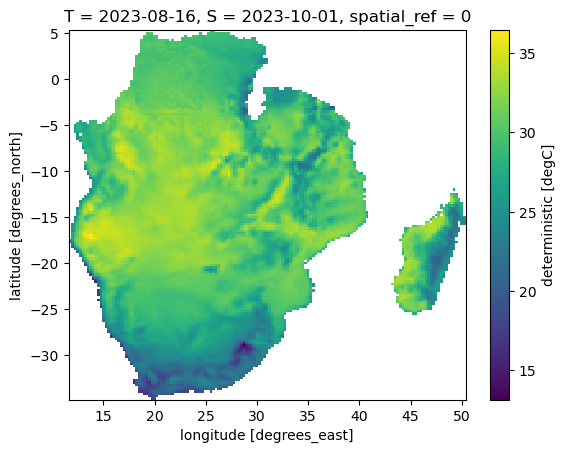

In [11]:
_data.rio.set_spatial_dims("X","Y")
_data=_data.rio.write_crs("epsg:4326")

overlay=gpd.read_file(overlayfile)
_data=_data.rio.clip(overlay.geometry.values, "epsg:4326")
_data.plot()

In [9]:
import geopandas as gpd